### Conclusion
* Right angle + power > just power or just angle
* hit the sweet spot but keep ld not too high
* top players have their ways to survive in the league
* Power/angle/eye/speed


### Finding
* Pay attention to /players/p/pierza.01.shtml only player id with "."
* 681 unduplicated batters >= 162 PA between 2015 and 2019
* 1925 data points >= 162 PA between 2015 and 2019
* Some % data are string data type = >need to convert if be used

### Completed
* Web-scraping on baseball reference by year to get the list of 2015-2019 batters
* Web-scraping on baseball reference by players to get advance stats
* Data frame
* Data into sql database
* Merge Baseball Reference data with Baseball Savant data
* EDA
* Decide baseline features
* split the data
* baseline model

### To do
* modeling
* cross validation

In [1]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

In [2]:
engine = create_engine('sqlite:///batters.db')

In [3]:
inspect(engine).get_table_names()

['br', 'players', 'statcast']

In [4]:
pd.read_sql('SELECT * FROM br;', engine).columns

Index(['index', 'Html_id', 'Name', 'Year', 'Age', 'Tm', 'Lg', 'G', 'PA', 'AB',
       'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP',
       'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB',
       'Pos_Summary', 'Awards', 'rOBA', 'Rbat+', 'BAbip', 'ISO', 'HR%', 'SO%',
       'BB%', 'EV', 'HardH%', 'LD%', 'GB%', 'FB%', 'GB/FB', 'Pull%', 'Cent%',
       'Oppo%', 'WPA', 'cWPA', 'RE24', 'RS%', 'SB%', 'XBT%', 'XBH%', 'X/H%',
       'SO/W', 'AB/SO', 'AB/HR', 'AB/RBI', 'GO/AO', 'IP%', 'HR/FB', 'IF/FB',
       'PA_cum', 'PA_cum_0', 'MLB_year', 'PA_0', 'PA_3y', 'PA_3y_0', 'PA_2y',
       'PA_2y_0', 'OPS+_3y', 'OPS+_3y_0', 'OPS+_2y', 'OPS+_2y_0', 'OPS+_last',
       'OPS+_next', 'Debut', 'Debut_Age'],
      dtype='object')

In [5]:
pd.read_sql('SELECT * FROM statcast;', engine).columns

Index(['index', 'last_name', 'first_name', 'player_id', 'year', 'player_age',
       'b_total_pa', 'b_total_hits', 'b_home_run', 'b_total_pitches',
       'exit_velocity_avg', 'launch_angle_avg', 'sweet_spot_percent',
       'barrels', 'barrel_batted_rate', 'hard_hit_percent', 'z_swing_percent',
       'z_swing_miss_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'out_zone_swing_miss', 'out_zone_swing',
       'out_zone_percent', 'meatball_swing_percent', 'meatball_percent',
       'iz_contact_percent', 'in_zone_percent', 'whiff_percent',
       'swing_percent', 'f_strike_percent', 'popups_percent', 'hp_to_1b',
       'sprint_speed', 'Unnamed: 33', 'z_s_contact_percent', '19_LA'],
      dtype='object')

In [543]:
########must run to update############
df = pd.read_sql('''SELECT b.name, s.first_name, s.last_name, b.year, b.mlb_year, b.age,
                           b.[ops+_last], b.[ops+_3y_0], b.[ops+_2y_0],
                           b.pa, b.pa_cum_0, b.pa_0, b.pa_2y_0, b.pa_3y_0, 
                           s.b_total_pitches * 1.0 / b.pa [p/pa], 
                           b.ev, b.[hardh%], s.launch_angle_avg, s.sweet_spot_percent, s.barrel_batted_rate,
                           b.[ld%], b.[gb%], b.[fb%], b.[gb/fb], 
                           b.[pull%], b.[cent%], b.[oppo%], 
                           b.[so/w], b.[go/ao], b.[ip%], b.[hr/fb], b.[if/fb],
                           s.z_swing_percent, s.z_swing_miss_percent, s.iz_contact_percent,
                           s.oz_swing_percent, s.oz_swing_miss_percent, s.oz_contact_percent,
                           s.meatball_swing_percent, s.whiff_percent, s.swing_percent,
                           s.popups_percent, s.sprint_speed, b.slg, b.babip, b.ops,b.[ops+]
                     FROM br b
                     JOIN statcast s
                     ON b.year = s.year
                     AND b.pa = s.b_total_pa
                     AND b.h = s.b_total_hits
                     AND b.hr = s.b_home_run;''', engine)#.dropna(how='any') 
#s.hp_to_1b, 
#Feature Engineering
df['Debut'] = pd.get_dummies(df.PA_3y_0, dummy_na=True).iloc[:, -1]
df['PA_0'] = df['PA_0'].fillna(0)
df['PA_2y_0'] = df['PA_2y_0'].fillna(0)
df['PA_3y_0'] = df['PA_3y_0'].fillna(0)
df['OPS+_last'].fillna(100, inplace=True)
df['OPS+_2y_0'].fillna(100, inplace=True)
df['OPS+_3y_0'].fillna(100, inplace=True)
df['Debut_Age'] = df['Age'] - df['MLB_year']
df['19_LA'] = df['launch_angle_avg'].map(lambda x : abs(x-19))
df['z_s_contact_percent'] = df['z_swing_percent'] * df['iz_contact_percent'] / 100
df['z_tot_miss_percent'] = 100 - df['z_swing_percent'] + df['z_swing_percent']*df['z_swing_miss_percent']/100
df['barrel_hard'] = df['HardH%'] - df['barrel_batted_rate'] 
df['barrel_sweet'] = df['sweet_spot_percent'] - df['barrel_batted_rate']
df['zcontact_ocontact'] = df['iz_contact_percent'] + df['oz_contact_percent']
df['zswing_oswing'] = df['z_swing_percent'] - df['oz_swing_percent']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1925 non-null   object 
 1   first_name              1925 non-null   object 
 2   last_name               1925 non-null   object 
 3   Year                    1925 non-null   int64  
 4   MLB_year                1925 non-null   int64  
 5   Age                     1925 non-null   int64  
 6   OPS+_last               1925 non-null   float64
 7   OPS+_3y_0               1925 non-null   float64
 8   OPS+_2y_0               1925 non-null   float64
 9   PA                      1925 non-null   int64  
 10  PA_cum_0                1925 non-null   int64  
 11  PA_0                    1925 non-null   float64
 12  PA_2y_0                 1925 non-null   float64
 13  PA_3y_0                 1925 non-null   float64
 14  p/pa                    1925 non-null   

In [544]:
df.describe()

,Year,MLB_year,Age,OPS+_last,OPS+_3y_0,OPS+_2y_0,PA,PA_cum_0,PA_0,PA_2y_0,...,BAbip,OPS,OPS+,Debut,Debut_Age,19_LA,z_s_contact_percent,z_tot_miss_percent,barrel_hard,barrel_sweet
count,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,...,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000
mean,2017.021818,5.182857,28.334026,98.634286,97.300693,97.887532,428.038961,2109.433766,370.684156,358.252468,...,0.299828,0.747045,99.023377,0.071169,23.151169,7.044935,55.348532,44.298931,32.572623,26.523169
std,1.419914,3.870140,3.855108,36.883706,33.002469,33.695819,161.897648,2155.266875,222.436071,211.120128,...,0.037456,0.100044,25.361441,0.257173,1.893611,4.092697,5.135395,5.154111,5.957532,4.720128
min,2015.000000,0.000000,19.000000,-100.000000,-100.000000,-100.000000,162.000000,0.000000,0.000000,0.000000,...,0.145000,0.433000,11.000000,0.000000,19.000000,0.000000,39.028800,21.108000,8.700000,4.800000
25%,2016.000000,2.000000,25.000000,84.000000,83.333333,84.500000,280.000000,404.000000,187.000000,182.000000,...,0.275000,0.681000,82.000000,0.000000,22.000000,3.800000,51.685200,40.792600,29.000000,23.300000
50%,2017.000000,4.000000,28.000000,100.000000,100.000000,100.000000,428.000000,1422.000000,401.000000,386.000000,...,0.300000,0.742000,98.000000,0.000000,23.000000,6.800000,55.257500,44.401600,33.000000,26.500000
75%,2018.000000,8.000000,31.000000,116.000000,112.666667,113.500000,568.000000,3140.000000,566.000000,535.000000,...,0.325000,0.809000,116.000000,0.000000,24.000000,9.800000,58.911200,47.997500,36.500000,29.800000
max,2019.000000,21.000000,43.000000,559.000000,559.000000,559.000000,747.000000,11964.000000,745.000000,734.000000,...,0.411000,1.109000,198.000000,1.000000,34.000000,20.500000,78.892000,60.971200,52.900000,42.200000


Baseline-> all training data  / cross-val(K1 K2 K3 K4 K5) / Test 20%

SELECT FEATURES/FEATURE ENIGERING  -> CROSS-VAL -> k2 MODEL -> TEST
5~10 FEATURES 


## Split data

In [558]:
##########must run##########
#X, y = df.drop('OPS+',axis=1), df['OPS+']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
df_train, df_test = train_test_split(df, test_size=.2, random_state=42)

## Baseline

In [9]:
select_columns = []

In [93]:
X_train = df_train[['Age', 'Debut','OPS+_2y_0','PA_2y_0','PA_cum_0','p/pa','HardH%','sweet_spot_percent',
                   'LD%','GB/FB','Pull%','z_swing_percent', 'iz_contact_percent', 
                    'oz_swing_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     89.56
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          1.47e-196
Time:                        19:48:21   Log-Likelihood:                -6676.0
No. Observations:                1540   AIC:                         1.338e+04
Df Residuals:                    1524   BIC:                         1.347e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -236.3741     30.282     -7.806      0.000    -295.773    -176.975
Age                   -1.0237      0.224     -4.565      0.000      -1.464      -0.584
Debut                  3.6273      2.237      1.622      0.105      -0.760       8.014
OPS+_2y_0              0.0581      0.015      3.812      0.000       0.028       0.088
PA_2y_0                0.0114      0.004      3.174      0.002       0.004       0.019
PA_cum_0               0.0008      0.000      1.831      0.067   -5.72e-05       0.002
p/pa                   7.0108      3.288      2.132      0.033       0.561      13.460
HardH%                 1.5671      0.066     23.598      0.000       1.437       1.697
sweet_spot_percent     1.8303      0.201      9.091      0.000       1.435       2.225
LD%                    0.0381      0.209      0.182      0.855      -0.372       0.449
GB/FB                  0.4322      0.747      0.579      0.563      -1.033       1.898
Pull%                  0.3492      0.082      4.249      0.000       0.188       0.510
z_swing_percent        0.4501      0.119      3.791      0.000       0.217       0.683
iz_contact_percent     1.2459      0.122     10.212      0.000       1.007       1.485
oz_swing_percent      -0.2815      0.111     -2.542      0.011      -0.499      -0.064
sprint_speed           2.4395      0.375      6.501      0.000       1.703       3.176
==============================================================================
Omnibus:                        0.126   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.115
Skew:                          -0.021   Prob(JB):                        0.944
Kurtosis:                       3.001   Cond. No.                     2.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [103]:
#takeout 'LD%','GB/FB'
X_train = df_train[['Age', 'Debut','OPS+_2y_0','PA_2y_0','PA_cum_0','p/pa','HardH%','sweet_spot_percent',
                   'Pull%','z_swing_percent', 'iz_contact_percent', 'oz_swing_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     103.4
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          1.82e-198
Time:                        19:54:34   Log-Likelihood:                -6676.3
No. Observations:                1540   AIC:                         1.338e+04
Df Residuals:                    1526   BIC:                         1.346e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -233.5205     29.820     -7.831      0.000    -292.014    -175.027
Age                   -1.0191      0.224     -4.549      0.000      -1.459      -0.580
Debut                  3.6207      2.233      1.621      0.105      -0.760       8.001
OPS+_2y_0              0.0572      0.015      3.770      0.000       0.027       0.087
PA_2y_0                0.0113      0.004      3.142      0.002       0.004       0.018
PA_cum_0               0.0008      0.000      1.829      0.068   -5.79e-05       0.002
p/pa                   6.6786      3.253      2.053      0.040       0.298      13.060
HardH%                 1.5666      0.066     23.652      0.000       1.437       1.697
sweet_spot_percent     1.8250      0.121     15.102      0.000       1.588       2.062
Pull%                  0.3316      0.078      4.240      0.000       0.178       0.485
z_swing_percent        0.4449      0.118      3.757      0.000       0.213       0.677
iz_contact_percent     1.2573      0.120     10.495      0.000       1.022       1.492
oz_swing_percent      -0.2837      0.111     -2.565      0.010      -0.501      -0.067
sprint_speed           2.4583      0.374      6.576      0.000       1.725       3.192
==============================================================================
Omnibus:                        0.159   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.923   Jarque-Bera (JB):                0.141
Skew:                          -0.023   Prob(JB):                        0.932
Kurtosis:                       3.006   Cond. No.                     1.98e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [141]:
#takeout 'Debut','p/pa'
X_train = df_train[['Age', 'OPS+_2y_0','PA_2y_0','HardH%','sweet_spot_percent',
                   'Pull%','z_swing_percent', 'iz_contact_percent', 'oz_swing_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     132.4
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          4.78e-199
Time:                        20:15:10   Log-Likelihood:                -6682.3
No. Observations:                1540   AIC:                         1.339e+04
Df Residuals:                    1529   BIC:                         1.345e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -200.4141     19.980    -10.031      0.000    -239.605    -161.223
Age                   -0.7589      0.155     -4.884      0.000      -1.064      -0.454
OPS+_2y_0              0.0628      0.015      4.210      0.000       0.034       0.092
PA_2y_0                0.0120      0.003      4.330      0.000       0.007       0.018
HardH%                 1.6041      0.065     24.495      0.000       1.476       1.733
sweet_spot_percent     1.8878      0.118     15.987      0.000       1.656       2.119
Pull%                  0.3551      0.078      4.566      0.000       0.203       0.508
z_swing_percent        0.3367      0.105      3.196      0.001       0.130       0.543
iz_contact_percent     1.1595      0.104     11.141      0.000       0.955       1.364
oz_swing_percent      -0.3719      0.100     -3.705      0.000      -0.569      -0.175
sprint_speed           2.4707      0.373      6.624      0.000       1.739       3.202
==============================================================================
Omnibus:                        0.070   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.966   Jarque-Bera (JB):                0.046
Skew:                          -0.012   Prob(JB):                        0.977
Kurtosis:                       3.011   Cond. No.                     1.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [199]:
#3y rolling, add barrel_batted_rate
X_train = df_train[['Age', 'OPS+_3y_0','PA_3y_0','HardH%','sweet_spot_percent','barrel_batted_rate',
                   'Pull%','z_swing_percent', 'iz_contact_percent', 'oz_swing_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     160.3
Date:                Fri, 24 Sep 2021   Prob (F-statistic):          2.75e-245
Time:                        20:40:15   Log-Likelihood:                -6571.8
No. Observations:                1540   AIC:                         1.317e+04
Df Residuals:                    1528   BIC:                         1.323e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -224.3226     18.782    -11.944      0.000    -261.164    -187.482
Age                   -0.6466      0.149     -4.353      0.000      -0.938      -0.355
OPS+_3y_0              0.0384      0.014      2.666      0.008       0.010       0.067
PA_3y_0                0.0098      0.003      3.558      0.000       0.004       0.015
HardH%                 0.6702      0.086      7.764      0.000       0.501       0.840
sweet_spot_percent     1.2490      0.118     10.622      0.000       1.018       1.480
barrel_batted_rate     3.2617      0.214     15.230      0.000       2.842       3.682
Pull%                  0.0990      0.074      1.333      0.183      -0.047       0.245
z_swing_percent        0.3981      0.098      4.052      0.000       0.205       0.591
iz_contact_percent     1.8809      0.108     17.339      0.000       1.668       2.094
oz_swing_percent      -0.4034      0.094     -4.313      0.000      -0.587      -0.220
sprint_speed           2.6491      0.347      7.627      0.000       1.968       3.330
==============================================================================
Omnibus:                        4.212   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                4.184
Skew:                          -0.128   Prob(JB):                        0.123
Kurtosis:                       3.008   Cond. No.                     1.85e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [222]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1540 entries, 426 to 1126
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1540 non-null   object 
 1   first_name              1540 non-null   object 
 2   last_name               1540 non-null   object 
 3   Year                    1540 non-null   int64  
 4   MLB_year                1540 non-null   int64  
 5   Age                     1540 non-null   int64  
 6   Debut                   1540 non-null   int64  
 7   Debut_Age               1540 non-null   int64  
 8   OPS+_last               1540 non-null   float64
 9   OPS+_3y_0               1540 non-null   float64
 10  OPS+_2y_0               1540 non-null   float64
 11  PA                      1540 non-null   int64  
 12  PA_cum_0                1540 non-null   int64  
 13  PA_0                    1540 non-null   float64
 14  PA_2y_0                 1540 non-null 

In [286]:
r_2 = []
for col in range(4, 49):
    X_train = df_train.iloc[:, col:col+1]
    y_train = df_train['OPS+']
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    #print(df_train.columns[col] + ":" + str(lm.score(X_train, y_train)))
    r_2.append((lm.score(X_train, y_train),df_train.columns[col]))

In [362]:
X_train = df_train[['barrel_batted_rate','EV','BAbip','OPS+_3y_0','PA_3y_0','IP%','19_LA','p/pa',
                   'oz_swing_percent','Pull%','popups_percent','z_s_contact_percent','oz_contact_percent',
                   'z_swing_percent','MLB_year']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     351.3
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:53:22   Log-Likelihood:                -6011.8
No. Observations:                1540   AIC:                         1.206e+04
Df Residuals:                    1524   BIC:                         1.214e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -168.6892     22.049     -7.651      0.000    -211.939    -125.439
barrel_batted_rate      4.2268      0.158     26.747      0.000       3.917       4.537
EV                      0.9428      0.188      5.013      0.000       0.574       1.312
BAbip                 379.2170      9.514     39.860      0.000     360.556     397.878
OPS+_3y_0               0.0209      0.010      2.082      0.038       0.001       0.041
PA_3y_0                 0.0087      0.002      4.173      0.000       0.005       0.013
IP%                    -0.0970      0.117     -0.829      0.408      -0.327       0.133
19_LA                  -0.3248      0.113     -2.885      0.004      -0.546      -0.104
p/pa                   -5.5505      2.397     -2.316      0.021     -10.251      -0.849
oz_swing_percent       -0.8733      0.074    -11.799      0.000      -1.018      -0.728
Pull%                   0.4306      0.055      7.762      0.000       0.322       0.539
popups_percent          0.7648      0.141      5.409      0.000       0.487       1.042
z_s_contact_percent     0.0167      0.002      9.878      0.000       0.013       0.020
oz_contact_percent      0.8295      0.057     14.667      0.000       0.719       0.940
z_swing_percent        -0.9717      0.132     -7.377      0.000      -1.230      -0.713
MLB_year               -0.4249      0.102     -4.183      0.000      -0.624      -0.226
==============================================================================
Omnibus:                        7.052   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                8.361
Skew:                           0.070   Prob(JB):                       0.0153
Kurtosis:                       3.333   Cond. No.                     4.00e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [463]:
df_train['z_tot_miss_percent'] = 100 - df_train['z_swing_percent'] + df_train['z_swing_percent'] * df_train['z_swing_miss_percent']/100

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_2120/1231422541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['z_tot_miss_percent'] = 100 - df_train['z_swing_percent'] + df_train['z_swing_percent'] * df_train['z_swing_miss_percent']/100


In [515]:
df_train['z_tot_miss_percent'] + df_train['z_s_contact_percent']/100

426     100.0000
141      98.8457
1022    100.0000
694     100.0000
1799     99.5710
          ...   
1130     99.1516
1294     99.9048
860      97.6753
1459    100.0000
1126    100.0000
Length: 1540, dtype: float64

In [540]:
X_train = df_train[['barrel_batted_rate','HardH%','sweet_spot_percent','FB%','swing_percent','Age',
                    'z_s_contact_percent','oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     258.5
Date:                Sat, 25 Sep 2021   Prob (F-statistic):          1.24e-299
Time:                        07:56:14   Log-Likelihood:                -6450.8
No. Observations:                1540   AIC:                         1.292e+04
Df Residuals:                    1530   BIC:                         1.297e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -34.8484     13.396     -2.601      0.009     -61.125      -8.572
barrel_batted_rate        4.2132      0.209     20.204      0.000       3.804       4.622
HardH%                    0.6575      0.081      8.118      0.000       0.499       0.816
sweet_spot_percent        1.3928      0.110     12.691      0.000       1.178       1.608
FB%                      -0.5222      0.101     -5.165      0.000      -0.721      -0.324
swing_percent            -1.5676      0.129    -12.197      0.000      -1.820      -1.315
Age                      -0.3932      0.121     -3.261      0.001      -0.630      -0.157
z_s_contact_percent       0.0156      0.001     12.107      0.000       0.013       0.018
oz_swing_miss_percent    -0.9659      0.056    -17.363      0.000      -1.075      -0.857
sprint_speed              3.0748      0.319      9.626      0.000       2.448       3.701
==============================================================================
Omnibus:                       10.066   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.177
Skew:                          -0.189   Prob(JB):                      0.00617
Kurtosis:                       2.876   Cond. No.                     1.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [287]:
r_2.sort(reverse=True)
r_2

[(0.8492653262605544, 'SLG'),
 (0.3189747811154583, 'HR/FB'),
 (0.31443498471870945, 'barrel_batted_rate'),
 (0.26426603358932077, 'EV'),
 (0.259062259271874, 'HardH%'),
 (0.24722268088177868, 'BAbip'),
 (0.21462439830499402, 'PA'),
 (0.14279630836762958, 'sweet_spot_percent'),
 (0.11620001004412805, 'SO/W'),
 (0.07046023449879457, 'LD%'),
 (0.068306447874256, 'OPS+_2y_0'),
 (0.06723912878100491, 'OPS+_3y_0'),
 (0.06028869520893332, 'OPS+_last'),
 (0.05605972341703236, 'FB%'),
 (0.04855856052534502, 'GB%'),
 (0.04790290313982204, 'GB/FB'),
 (0.042224766827248295, 'PA_2y_0'),
 (0.04146768036794635, 'PA_3y_0'),
 (0.04008122905160305, 'PA_0'),
 (0.03071442801324642, 'IF/FB'),
 (0.02843354613227811, 'IP%'),
 (0.027341291444626603, '19_LA'),
 (0.026256199719881468, 'p/pa'),
 (0.025240591462348583, 'launch_angle_avg'),
 (0.017305952629821486, 'Debut_Age'),
 (0.01695367832422734, 'oz_swing_percent'),
 (0.016916481001717165, 'swing_percent'),
 (0.013056512756394856, 'GO/AO'),
 (0.0118997786225

In [525]:
df_train[['barrel_hard','barrel_sweet', 'barrel_batted_rate']].describe()

,barrel_hard,barrel_sweet,barrel_batted_rate
count,1540.000000,1540.000000,1540.000000
mean,32.635325,26.577727,6.594026
std,5.915485,4.738731,3.958927
min,11.100000,4.800000,0.000000
25%,29.175000,23.400000,3.600000
50%,33.000000,26.500000,6.100000
75%,36.600000,29.900000,9.100000
max,52.900000,42.200000,26.400000


In [576]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age','swing_percent',
                    'z_s_contact_percent','oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     258.5
Date:                Sat, 25 Sep 2021   Prob (F-statistic):          1.24e-299
Time:                        08:16:44   Log-Likelihood:                -6450.8
No. Observations:                1540   AIC:                         1.292e+04
Df Residuals:                    1530   BIC:                         1.297e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -34.8484     13.396     -2.601      0.009     -61.125      -8.572
barrel_batted_rate        6.2634      0.173     36.180      0.000       5.924       6.603
barrel_hard               0.6575      0.081      8.118      0.000       0.499       0.816
barrel_sweet              1.3928      0.110     12.691      0.000       1.178       1.608
FB%                      -0.5222      0.101     -5.165      0.000      -0.721      -0.324
Age                      -0.3932      0.121     -3.261      0.001      -0.630      -0.157
swing_percent            -1.5676      0.129    -12.197      0.000      -1.820      -1.315
z_s_contact_percent       1.5628      0.129     12.107      0.000       1.310       1.816
oz_swing_miss_percent    -0.9659      0.056    -17.363      0.000      -1.075      -0.857
sprint_speed              3.0748      0.319      9.626      0.000       2.448       3.701
==============================================================================
Omnibus:                       10.066   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.177
Skew:                          -0.189   Prob(JB):                      0.00617
Kurtosis:                       2.876   Cond. No.                     3.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [615]:
df_train['contact'] = 100 - df_train['whiff_percent']
df_train['contact'].describe()

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_2120/2663788121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['contact'] = 100 - df_train['whiff_percent']


count    1540.000000
mean       76.147662
std         6.247609
min        56.000000
25%        72.000000
50%        76.200000
75%        80.625000
max        92.200000
Name: contact, dtype: float64

In [632]:
df_train['z_no_swing'] = 100 - df_train['z_swing_percent']
df_train['z_no_swing'].describe()

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_2120/3506880252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['z_no_swing'] = 100 - df_train['z_swing_percent']


count    1540.000000
mean       33.147338
std         5.832844
min        16.500000
25%        29.300000
50%        33.200000
75%        37.200000
max        52.400000
Name: z_no_swing, dtype: float64

In [651]:
df_train['o_s_miss_percent'] = df_train['oz_swing_percent'] * df_train['oz_swing_miss_percent'] / 100
df_train['o_s_miss_percent'].describe()

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_2120/3667471401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['o_s_miss_percent'] = df_train['oz_swing_percent'] * df_train['oz_swing_miss_percent'] / 100


count    1540.000000
mean       11.282109
std         3.381350
min         3.050000
25%         8.893375
50%        10.974250
75%        13.496600
max        27.602400
Name: o_s_miss_percent, dtype: float64

In [692]:
df_train['zswing_no_oswing'] = df_train['z_swing_percent'] / 2  + (100 -  df_train['oz_swing_percent'])/2
df_train['zswing_no_oswing'].describe()

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_2120/1915382333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['zswing_no_oswing'] = df_train['z_swing_percent'] / 2  + (100 -  df_train['oz_swing_percent'])/2


count    1540.000000
mean       69.256688
std         2.814423
min        59.550000
25%        67.450000
50%        69.300000
75%        71.100000
max        78.750000
Name: zswing_no_oswing, dtype: float64

In [747]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age','z_swing_percent', 'oz_swing_percent',
                    'iz_contact_percent','oz_swing_miss_percent','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     225.7
Date:                Sat, 25 Sep 2021   Prob (F-statistic):          1.66e-292
Time:                        22:16:47   Log-Likelihood:                -6464.5
No. Observations:                1540   AIC:                         1.295e+04
Df Residuals:                    1529   BIC:                         1.301e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -124.8099     17.729     -7.040      0.000    -159.586     -90.034
barrel_batted_rate        6.4242      0.177     36.220      0.000       6.076       6.772
barrel_hard               0.6820      0.082      8.343      0.000       0.522       0.842
barrel_sweet              1.3733      0.111     12.343      0.000       1.155       1.591
FB%                      -0.5049      0.102     -4.934      0.000      -0.706      -0.304
Age                      -0.3705      0.122     -3.045      0.002      -0.609      -0.132
z_swing_percent           0.5678      0.091      6.237      0.000       0.389       0.746
oz_swing_percent         -0.6952      0.088     -7.913      0.000      -0.868      -0.523
iz_contact_percent        1.0432      0.116      8.961      0.000       0.815       1.271
oz_swing_miss_percent    -0.9873      0.064    -15.312      0.000      -1.114      -0.861
sprint_speed              2.9480      0.322      9.145      0.000       2.316       3.580
==============================================================================
Omnibus:                        8.068   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.181
Skew:                          -0.175   Prob(JB):                       0.0167
Kurtosis:                       2.930   Cond. No.                     5.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [718]:
df_train['zswing_oswing'] = df_train['z_swing_percent'] - df_train['oz_swing_percent']
df_train['zswing_oswing'].describe()

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_2120/1309249371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['zswing_oswing'] = df_train['z_swing_percent'] - df_train['oz_swing_percent']


count    1540.000000
mean       38.513377
std         5.628847
min        19.100000
25%        34.900000
50%        38.600000
75%        42.200000
max        57.500000
Name: zswing_oswing, dtype: float64

In [730]:
df_train['zcontact_ocontact'] = df_train['iz_contact_percent'] + df_train['oz_contact_percent']
df_train['zcontact_ocontact'].describe()

/var/folders/5j/jyxtrn7n0cl1j0jb8nzdk5dr0000gn/T/ipykernel_2120/3241522522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['zcontact_ocontact'] = df_train['iz_contact_percent'] + df_train['oz_contact_percent']


count    1540.000000
mean      142.214935
std        14.030187
min        92.600000
25%       133.200000
50%       142.300000
75%       152.100000
max       180.600000
Name: zcontact_ocontact, dtype: float64

In [744]:
X_train = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','zswing_oswing',
                    'zcontact_ocontact','sprint_speed']]
y_train = df_train['OPS+']
model = sm.OLS(y_train, sm.add_constant(X_train)) 
fit = model.fit()

fit.summary()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   OPS+   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     317.7
Date:                Sat, 25 Sep 2021   Prob (F-statistic):          6.14e-293
Time:                        22:16:25   Log-Likelihood:                -6472.2
No. Observations:                1540   AIC:                         1.296e+04
Df Residuals:                    1532   BIC:                         1.300e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -248.3632     12.599    -19.714      0.000    -273.075    -223.651
barrel_batted_rate     6.3471      0.177     35.960      0.000       6.001       6.693
barrel_hard            0.6601      0.081      8.137      0.000       0.501       0.819
barrel_sweet           1.3374      0.111     12.033      0.000       1.119       1.555
FB%                   -0.5064      0.102     -4.946      0.000      -0.707      -0.306
zswing_oswing          0.6276      0.079      7.902      0.000       0.472       0.783
zcontact_ocontact      0.9896      0.038     26.165      0.000       0.915       1.064
sprint_speed           3.5209      0.289     12.174      0.000       2.954       4.088
==============================================================================
Omnibus:                        6.781   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.824
Skew:                          -0.163   Prob(JB):                       0.0330
Kurtosis:                       2.979   Cond. No.                     4.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [545]:
df_train.columns

Index(['Name', 'first_name', 'last_name', 'Year', 'MLB_year', 'Age', 'Debut',
       'Debut_Age', 'OPS+_last', 'OPS+_3y_0', 'OPS+_2y_0', 'PA', 'PA_cum_0',
       'PA_0', 'PA_2y_0', 'PA_3y_0', 'p/pa', 'EV', 'HardH%',
       'launch_angle_avg', 'sweet_spot_percent', 'barrel_batted_rate', 'LD%',
       'GB%', 'FB%', 'GB/FB', 'Pull%', 'Cent%', 'Oppo%', 'SO/W', 'GO/AO',
       'IP%', 'HR/FB', 'IF/FB', 'z_swing_percent', 'z_swing_miss_percent',
       'iz_contact_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'z_s_contact_percent', '19_LA',
       'meatball_swing_percent', 'whiff_percent', 'swing_percent',
       'popups_percent', 'sprint_speed', 'SLG', 'BAbip', 'OPS', 'OPS+',
       'z_tot_miss_percent', 'barrel_hard', 'barrel_sweet'],
      dtype='object')

## VIF

In [166]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [167]:
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [556]:
#'swing_percent','sprint_speed','HardH%','sweet_spot_percent',,'Age','FB%'
#vif(df_train[['barrel_batted_rate',
#                    'z_s_contact_percent','oz_swing_miss_percent']])
vif(df_train[['barrel_batted_rate','HardH%','sweet_spot_percent','FB%','swing_percent','Age',
                    'z_s_contact_percent','oz_swing_miss_percent','sprint_speed']])

barrel_batted_rate        14.856802
HardH%                    57.156500
sweet_spot_percent        75.766879
FB%                       31.325593
swing_percent            218.796927
Age                       47.399583
z_s_contact_percent      296.427375
oz_swing_miss_percent     31.295400
sprint_speed             150.014525
dtype: float64

In [592]:
vif(df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','swing_percent','Age',
                    'z_s_contact_percent','oz_swing_miss_percent','sprint_speed']])

barrel_batted_rate        10.676185
barrel_hard               38.112271
barrel_sweet              47.358849
FB%                       31.241800
swing_percent            123.697327
Age                       52.588168
z_tot_miss_percent       125.096981
oz_swing_miss_percent     29.935354
sprint_speed             262.471437
dtype: float64

In [697]:
vif(df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age','z_swing_percent', 'oz_swing_percent',
                    'iz_contact_percent','oz_swing_miss_percent','sprint_speed']])

barrel_batted_rate        10.779552
barrel_hard               42.214596
barrel_sweet              52.542715
FB%                       32.197544
Age                       59.920791
z_swing_percent          193.428416
oz_swing_percent          38.153561
iz_contact_percent       311.387458
oz_swing_miss_percent     35.861244
sprint_speed             266.422495
dtype: float64

In [734]:
vif(df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','zswing_oswing',
                    'zcontact_ocontact']])

barrel_batted_rate    10.078786
barrel_hard           36.732790
barrel_sweet          48.523431
FB%                   31.213100
zswing_oswing         43.906926
zcontact_ocontact     72.991452
dtype: float64

## Diagnostic_Plots

In [506]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

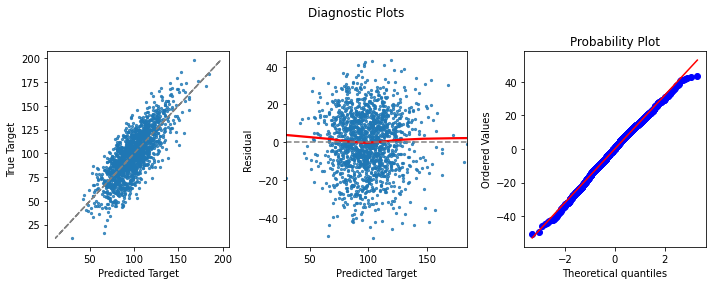

In [563]:
diagnostic_plots(fit.fittedvalues, y_train, fit.resid)

## EDA

In [709]:
df_eda = df_train[['barrel_batted_rate','barrel_hard','barrel_sweet','FB%','Age','zswing_oswing',
                    'iz_contact_percent','oz_swing_miss_percent','sprint_speed','OPS+']]

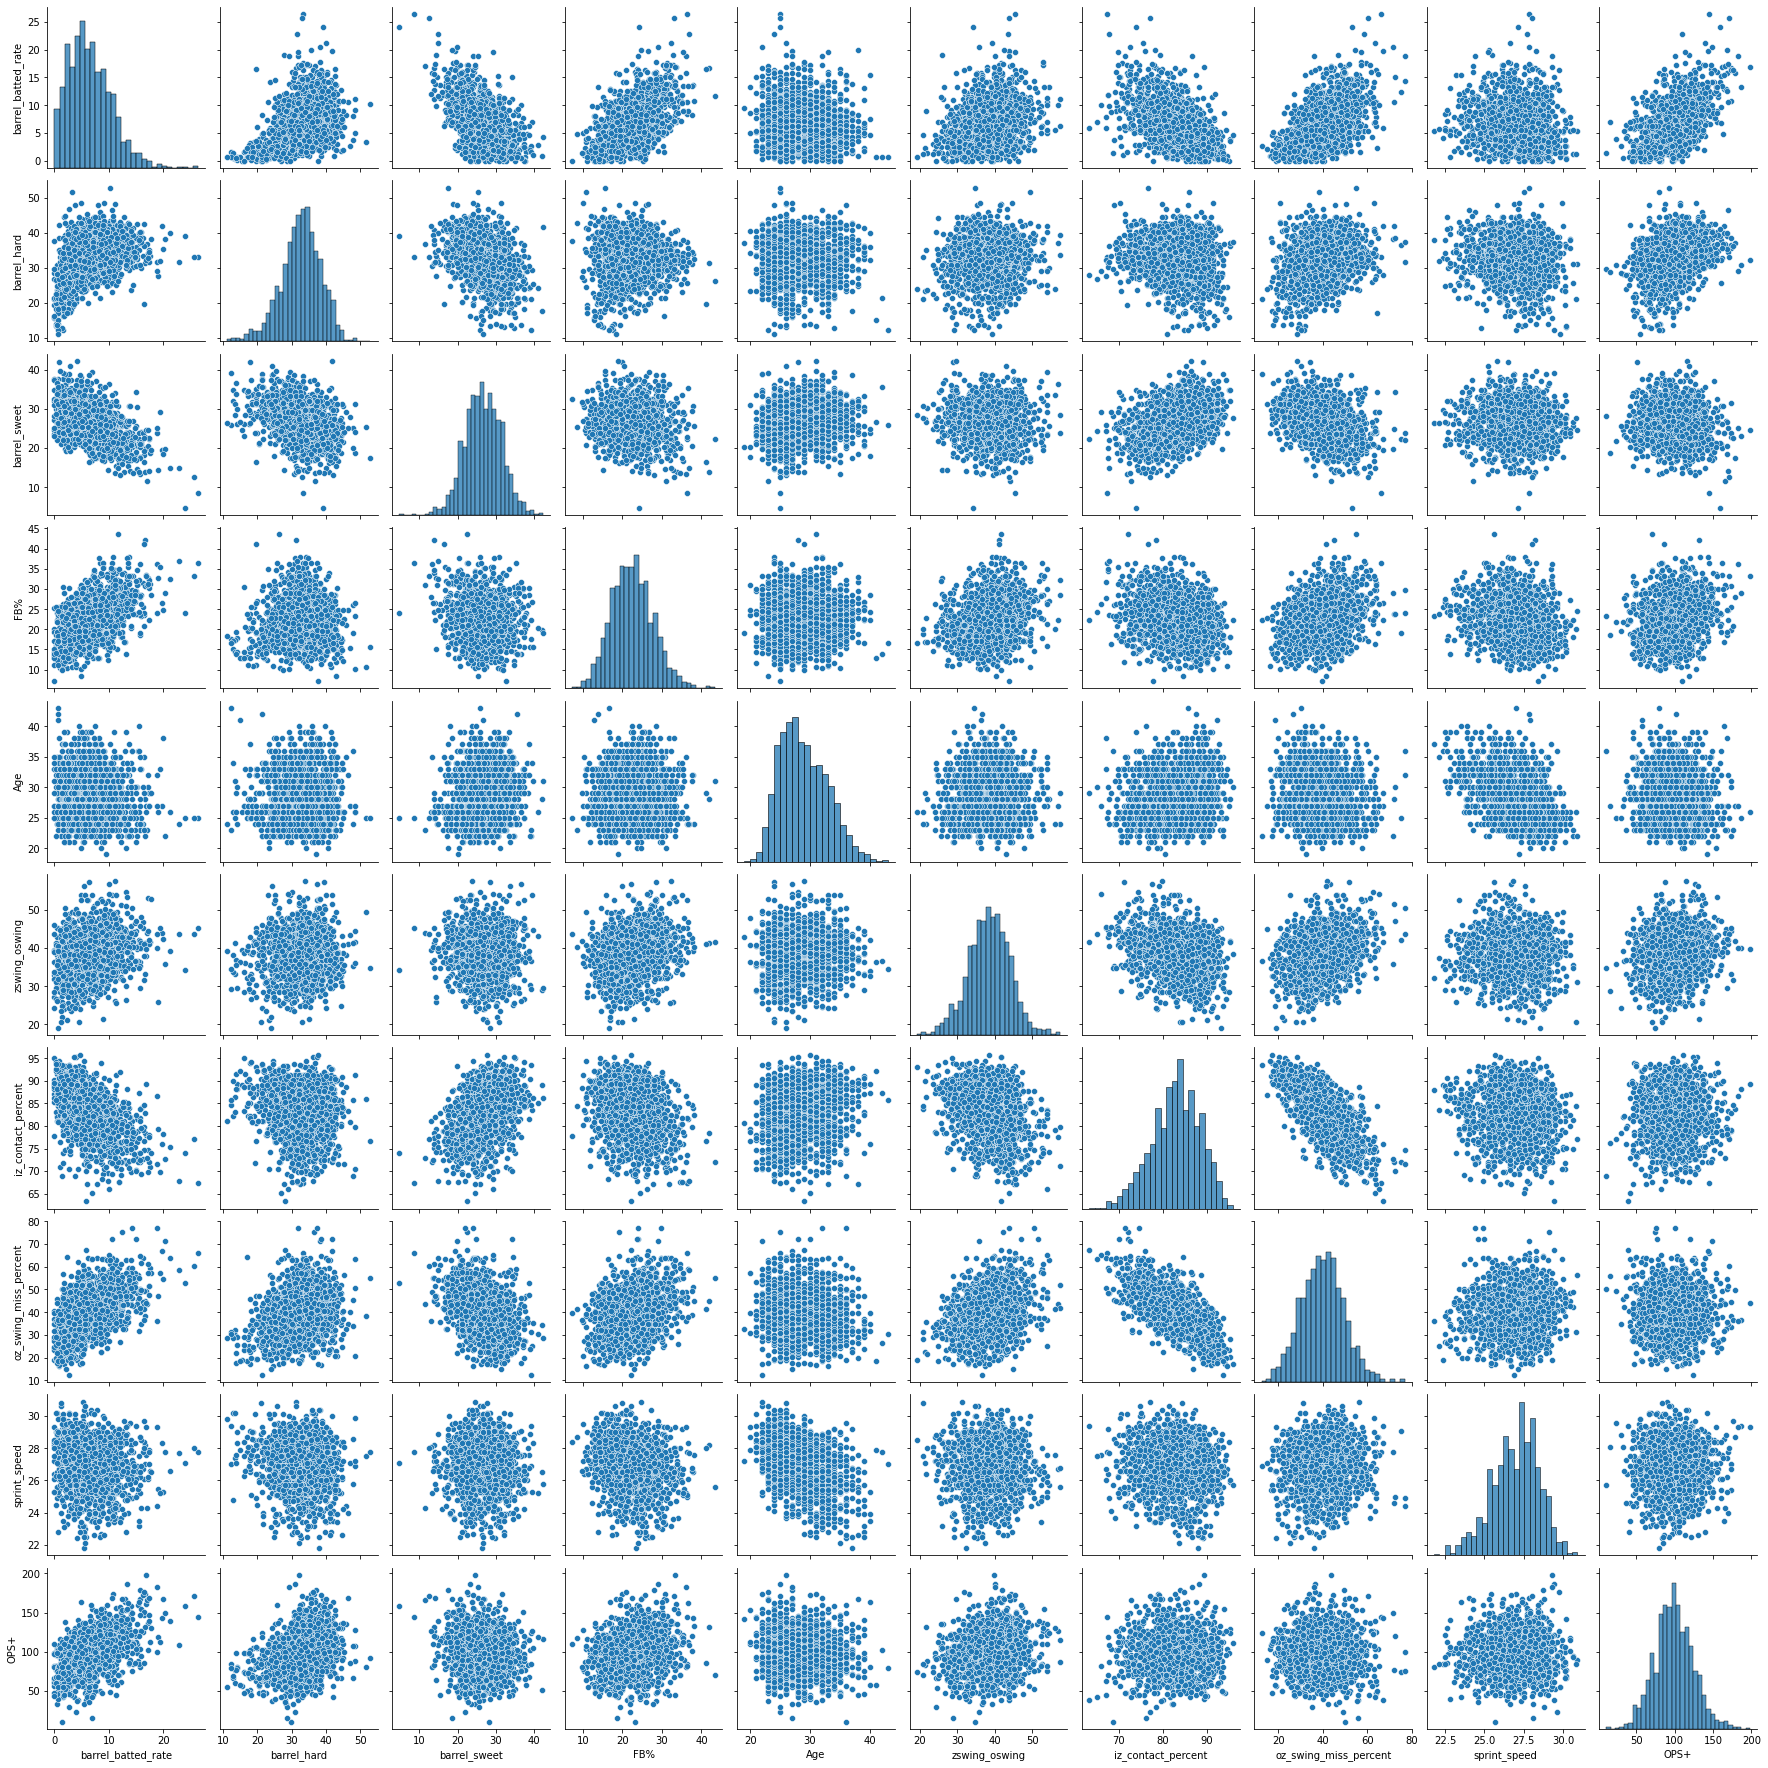

In [711]:
sns.pairplot(df_eda)
plt.savefig("pairplot.png", facecolor ="w", bbox_inches="tight");

In [712]:
df_eda.corr()

,barrel_batted_rate,barrel_hard,barrel_sweet,FB%,Age,zswing_oswing,iz_contact_percent,oz_swing_miss_percent,sprint_speed,OPS+
barrel_batted_rate,1.000000,0.401324,-0.555238,0.548508,-0.056457,0.241678,-0.524355,0.540043,-0.130440,0.560745
barrel_hard,0.401324,1.000000,-0.362234,0.000432,0.002721,0.088070,-0.139426,0.230773,-0.125671,0.341838
barrel_sweet,-0.555238,-0.362234,1.000000,-0.133683,0.106175,-0.039622,0.390878,-0.352256,-0.014361,-0.136829
FB%,0.548508,0.000432,-0.133683,1.000000,0.033621,0.238234,-0.285646,0.302728,-0.172458,0.236769
Age,-0.056457,0.002721,0.106175,0.033621,1.000000,0.013944,0.174979,-0.134411,-0.467125,-0.075615
zswing_oswing,0.241678,0.088070,-0.039622,0.238234,0.013944,1.000000,-0.301597,0.309130,-0.024275,0.173477
iz_contact_percent,-0.524355,-0.139426,0.390878,-0.285646,0.174979,-0.301597,1.000000,-0.708932,-0.087280,0.009620
oz_swing_miss_percent,0.540043,0.230773,-0.352256,0.302728,-0.134411,0.309130,-0.708932,1.000000,0.085535,-0.013304
sprint_speed,-0.130440,-0.125671,-0.014361,-0.172458,-0.467125,-0.024275,-0.087280,0.085535,1.000000,0.008696
OPS+,0.560745,0.341838,-0.136829,0.236769,-0.075615,0.173477,0.009620,-0.013304,0.008696,1.000000


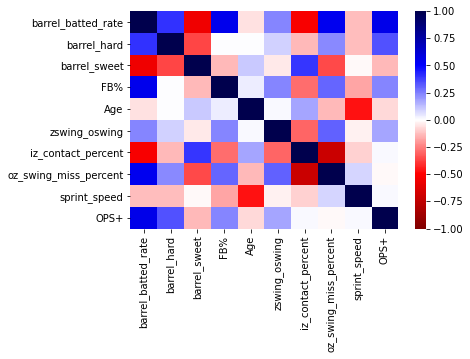

In [713]:
upper = np.triu(df_eda.corr())
sns.heatmap(df_eda.corr(), cmap="seismic_r", annot=False, vmin=-1, vmax=1);

In [180]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_ridge.coef_))

[('Age', -1.1652622567480791e-08),
 ('Debut', 3.701119890082847e-10),
 ('OPS+_3y_0', 3.4422266900786596e-07),
 ('PA_3y_0', 1.6364000044630364e-06),
 ('PA_cum_0', 6.501905169811993e-06),
 ('p/pa', 1.5058141698937449e-09),
 ('HardH%', 1.6543871844414952e-07),
 ('launch_angle_avg', 2.7295281824841452e-08),
 ('LD%', 3.72691776692361e-08),
 ('GB/FB', -7.187612588640868e-09),
 ('Pull%', 2.429764210324379e-08),
 ('Oppo%', -1.797188523269955e-08),
 ('z_swing_percent', 7.83367477911716e-09),
 ('iz_contact_percent', 2.01947022764044e-09),
 ('oz_swing_percent', -3.0249997944782546e-08),
 ('sprint_speed', 5.237250455147653e-10)]

In [181]:
lr_model_lasso = Lasso(alpha = 100000)
lr_model_lasso.fit(X_train, y_train)

list(zip(X_train.columns, lr_model_lasso.coef_))

[('Age', -0.0),
 ('Debut', 0.0),
 ('OPS+_3y_0', 0.0),
 ('PA_3y_0', 0.0),
 ('PA_cum_0', 0.0),
 ('p/pa', 0.0),
 ('HardH%', 0.0),
 ('launch_angle_avg', 0.0),
 ('LD%', 0.0),
 ('GB/FB', -0.0),
 ('Pull%', 0.0),
 ('Oppo%', -0.0),
 ('z_swing_percent', 0.0),
 ('iz_contact_percent', 0.0),
 ('oz_swing_percent', -0.0),
 ('sprint_speed', 0.0)]